In [3]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime

dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

In [4]:
fp = dir.joinpath('EHR', 'd_flo_measures.csv.gz')
dict = pd.read_csv(fp, compression="gzip")

names = ["State Behavioral Scale",
"-3 Unresponsive", 
"-2 Responsive to noxious stimuli", 
"-1 Responsive to gentle touch or voice",
"0 Awake and Able to calm",
"+1 Restless and difficult to calm",
"+2 Agitated",
"State Behavioral Scale (SBS)"]

# note: flowsheet record flow_meas_id as meas_id
# note: SBS score values are only stored in these fields

fmid = [304080016, 304080017, 304080018, 304080019, 304080020, 304080021]

In [5]:
# connect with feather file
fp = dir.joinpath('EHR', 'ptsd_record.csv.gz')

ptsd_record = pd.read_csv(fp, compression="gzip")

# load flow table of all patient EHR records
fp = dir.joinpath('EHR', 'flowsheet.csv.gz')
data = pd.read_csv(fp, compression="gzip")
data = data.drop(columns = ['meas_comment', 'meas_template_id'])
# Note: pandas took 50 seconds to load the table. Consider porting to PySpark RDD

sbs = data[data['meas_id'].isin(fmid)]
# print(sbs.shape)
# 25878 entries

# calculate sbs score from offset
sbs['SBS'] = sbs['meas_id'] - 304080019
sbs = sbs.drop(columns=['meas_value', 'meas_id'])
sbs['recorded_time'] = pd.to_datetime(sbs['recorded_time'], format='%Y-%m-%d %H:%M:%S')
sbs_indiv = sbs.groupby('pat_enc_csn_sid')

# load pre-selected patients from patient_inclexcl.ipynb
patients = np.load('./DONOTPUSH/patients_wodrugs.npy', allow_pickle=True)

C:\Users\fhuang15\AppData\Local\Temp\ipykernel_13900\528365614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbs['SBS'] = sbs['meas_id'] - 304080019


### Segment pstd and SBS data for ML training

Select Relevant vitals.
For now:
- drop data from Medibus (ventilator system)
- Keep dts, HR, SPO2, RR, BP

In [6]:
fp_hl7m = dir.joinpath('ptsd-phi', 'vitals-hl7m', "003", '1000000003-2016-07-07-0.0166667-1-HL7M.feather')
fp_tsdb = dir.joinpath('ptsd-phi', 'vitals-tsdb', "106", '1000002106-2019-01-22-1-TSDB.feather')
fp_gevital = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-GEVITAL.feather')
fp_medibus = dir.joinpath('ptsd-phi', 'vitals-sb', "672", '1000002672-2020-10-01-1-MEDIBUSVITAL.feather')

df = pd.read_feather(fp_hl7m, columns=None, use_threads=True, storage_options=None)
names_hl7m = df.columns.tolist()

# print("hl7m", names_hl7m)
df = pd.read_feather(fp_tsdb, columns=None, use_threads=True, storage_options=None)
names_tsdb = df.columns.tolist()
# print("tsdb", names_tsdb)

df = pd.read_feather(fp_gevital, columns=None, use_threads=True, storage_options=None)
names_gevitals = df.columns.tolist()
# print("gevitals", names_gevitals)

# df = pd.read_feather(fp_medibus, columns=None, use_threads=True, storage_options=None)
# names_medibus = df.columns.tolist()
# print("medibus", names_medibus)

In [14]:
tsdb_order = ['dts', 'HR', 'RR_2344', 'SpO2_7874', "PVC"]
hl7m_order = ['dts', 'HR', 'RR', 'SPO2-%', 'PVC']
ge_order = ['dts','PARM_HR','PARM_RESP_RATE', 'PARM_SPO2_1', 'PARM_PVC']

metrics = set(hl7m_order + tsdb_order + ge_order)
dims = len(hl7m_order)

In [15]:
# turn off error message on .loc
pd.options.mode.chained_assignment = None  # default='warn'

# vitals data
X = []
# sbs scores
y = []
# record patient id for stratification
ids = []
ctr = 1

for p in patients:
    if ctr % 50 == 0:
        print(f'[{ctr} / {len(patients)}]: {p}')

    files = ptsd_record[ptsd_record['pat_enc_csn_sid'] == p]
    files['start_time'] = pd.to_datetime(files['start_time'], format='%Y-%m-%d %H:%M:%S')
    files['end_time'] = pd.to_datetime(files['end_time'], format='%Y-%m-%d %H:%M:%S')
    files.sort_values('start_time')

    devices = files['device']
    filename = files['filename'] + '.feather'
    startime = files['start_time']

    dfs = []
    size = 0

    for (d, fn, t0) in zip(devices, filename, startime): 
        # drop 'MEDIBUSVITAL' since it is a ventilator (we dont want ventilated patients)
        if fn.endswith('MEDIBUSVITAL.feather'):
            continue
        # HL7M', 'TSDB', 'GEVITAL'
        if (d.endswith('HL7M') or d.endswith('TSDB')):
            fp_device = 'vitals-' + d.lower()
        else:
            fp_device = 'vitals-sb'
        fp_p = str(p)[-3:] # last 3 digit of pat_enc_csn_sid is the subfolder
        fp = dir.joinpath('ptsd-phi', fp_device, fp_p, fn)
        if (fp == None):
            print(fp, "does not exist")
            continue

        df = pd.read_feather(fp, columns=None, use_threads=True, storage_options=None)
        df = df.filter(metrics)
        # rearrange columns according to device
        if d.endswith('HL7M'):
            df = df.reindex(columns=hl7m_order)
        elif d.endswith('TSDB'):
            df = df.reindex(columns=tsdb_order)
        elif d.endswith('GEVITAL'):
            df = df.reindex(columns=ge_order)

        df.loc[:,'dts'] = pd.to_timedelta(df.loc[:,'dts'], unit='s')
        df.loc[:,'dts'] = df.loc[:,'dts'] + t0

        # standardize column names
        # time, heart rate, central venous pressure, resp rate and spo2-%
        df.columns = ['dts', 'HR', 'RR', 'SPO2-%', 'PVC']
        dfs.append(df)

    # resample to 1min intervals using median value
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
    vitals = (pd.concat(dfs, axis=0)
              .set_index('dts')
              .sort_values(by=['dts'])
              .resample('1T').median()
    )
    # add SBS
    sbs_p = (sbs_indiv.get_group(p)
            .sort_values('recorded_time')
            .drop(columns=['osler_sid', 'pat_enc_csn_sid'])
            .set_index('recorded_time')
            .resample('1T').median()
    )
    # preserve vitals timestamps while adding SBS where available
    patient_multi = pd.merge(left=vitals, right=sbs_p, left_index=True, right_index=True, how='left')


    for i in np.argwhere(~np.isnan(patient_multi['SBS'].tolist())):
        idx = i[0]
        if idx > 29:
            end = patient_multi.index[idx]
            start = end-timedelta(seconds=30*60)
            dat = patient_multi.loc[start:end, :]
            X.append(dat.drop(columns=['SBS']).to_numpy())
            y.append(patient_multi['SBS'][idx])
            ids.append(p)

    ctr += 1

X = np.array(X)
y = np.array(y)
ids = np.array(ids)

[50 / 415]: 1000002181
[100 / 415]: 1000002256
[150 / 415]: 1000002339
[200 / 415]: 1000002435
[250 / 415]: 1000002537
[300 / 415]: 1000002633
[350 / 415]: 1000002724
[400 / 415]: 1000002827


Sanity check dimensions, distribution of values, amount of NAs

In [24]:
# reshape
X = np.transpose(X, (0, 2, 1))

print(X.shape)
print(y.shape)
print(ids.shape)

(3482, 4, 31)
(3482,)
(3482,)


(array([8.812e+04, 1.289e+03, 3.950e+02, 2.220e+02, 1.360e+02, 1.150e+02,
        6.100e+01, 3.300e+01, 2.500e+01, 4.200e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

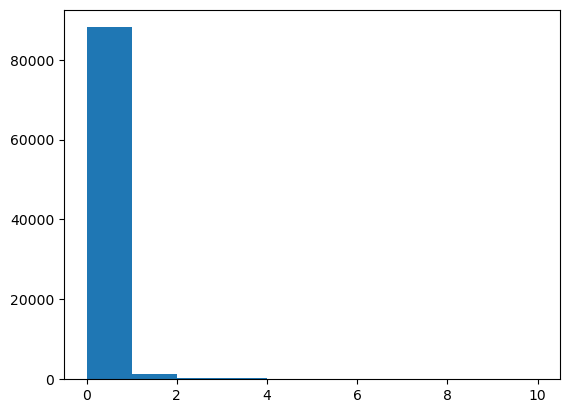

In [32]:
# ['dts', 'HR', 'RR', 'SPO2-%', 'PVC']

# hr = np.ravel(X[:,0,:])
# plt.hist(hr)

# rr = np.ravel(X[:,1,:])
# plt.hist(rr)

# Spo2 = np.ravel(X[:,2,:])
# plt.hist(Spo2)

pvc = np.ravel(X[:,3,:])
plt.hist(pvc, range=[0,10])

In [34]:
np.save('./DONOTPUSH/20230809_waveforms_30min.npy',X)
np.save('./DONOTPUSH/20230809_sbs_30min.npy',y)
np.save('./DONOTPUSH/20230809_ids_30min.npy',ids)

In [33]:
# Proportion of NA values
pnan = np.sum(np.sum(np.isnan(X), axis=2), axis=0) / (X.shape[0] * X.shape[2])
pnan

# ['dts', 'HR', 'RR', 'SPO2-%', 'PVC']

array([0.10838228, 0.16050286, 0.10875285, 0.16054918])